# MNIST Classification

The goal of this notebook is to implement a model consisting of just a softmax layer for classifying MNIST images, hence to perform a multiclass classification task. The notation follows the convention introduced for PW02:

<code>m</code>: Number of samples <br>
<code>n</code>: Number of features

Please follow the instructions in the cells below to conduct the following tasks:

1. Implement the functions to prepare the data (very similar to PW02).
2. Implement softmax, the cross entropy cost for multiclass and its gradient.
3. Implement the `optimize` function (with given function signature) by using the classes `Metrics` and `MiniBatches`.  
4. Run several trainings with different hyper-parameter settings and determine your favorite setting (1b).
5. Compute the Error Rates for the individual Digits (1c)
6. Analyze misclassified images with worst score (1d)
8. Plot the weights as images (1e)
7. Analyze different weights initialisation strategies (1f)

### Loading and Preparing the Data

Some preparatory steps to be applied before training:
* Imports: numpy and matplotlib
* Loading the data (same as for PW of previous week) 
* Some plot utilities
* Splitting the dataset into train and test
* Data Standarisation

In [8]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
### START YOUR CODE ### 
data_home = "/Users/Apple/Documents/Deep Learning/Data/SW03"
### END YOUR CODE ### 

#### Load Data

In [3]:
from sklearn.datasets import fetch_openml

def load_mnist(data_home):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images.     
    Parameters: 
    data_home -- Absolute path to the DATA_HOME  
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (1,m) where m is the number of images
    shape -- (28,28)
    """
    mnist = fetch_openml(name='mnist_784', version=1, cache=True, data_home=data_home)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)


#### Plotting Utility

In [4]:
def plot_img(img, label, shape):
    """
    Plot the x array by reshaping it into a square array of given shape
    and print the label.
    
    Parameters:
    img -- array with the intensities to be plotted of shape (shape[0]*shape[1])
    label -- label 
    shape -- 2d tuple with the dimensions of the image to be plotted.
    """
    plt.imshow(np.reshape(img, shape), cmap=plt.cm.gray)
    plt.title("Label %i"%label)


def plot_digits(x,y,selection,shape, cols=5):
    """
    Plots the digits in a mosaic with given number of columns.

    Arguments:
    x -- array of images of size (n,m)
    y -- array of labels of size (1,m)
    selection -- list of selection of samples to be plotted
    shape -- shape of the images (a 2d tuple)
    selected_digits -- tuple with the two selected digits (the first associated with label 1, the second with label 0)
    """
    if len(selection)==0:
        print("No images in the selection!")
        return
    cols = min(cols, len(selection))
    rows = len(selection)/cols+1
    plt.figure(figsize=(20,4*rows))
    for index, (image, label) in enumerate(zip(x.T[selection,:], y.T[selection,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, shape), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (selection[index],label), fontsize = 12)
    plt.tight_layout()

#### Split Data and reshape as specified

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' with 20\% test data.

Furthermore, we reshape input data x to (n,m).

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test(x, y, test_size=0.20):
    """
    Split the dataset consisting of an array of images (shape (n, m)) and an array of labels (shape (1, m))
    into train and test set.
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (1, m) where m is the number of samples
    test_size -- fraction of samples to reserve as test sample
    
    Returns:
    x_train -- np.ndarray of images of shape (n,m1) used for training
    y_train -- np.ndarray of labels of shape (1,m1) used for training
    x_test -- np.ndarray of images of shape (n,m2) used for testing
    y_test -- np.ndarray of labels of shape (1,m2) used for testing
    """
    # split 
    # train_test_split() expects x, y in shapes (m, *), (m, *) 
    
    out = train_test_split(x.T, y.T, test_size=0.20, random_state=1)
    
    # transpose back the output obtained from the train_test_split-function
    x_train, x_test, y_train, y_test = (x.T for x in out)
    
    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test

#### Data Normalisation

Normalize the data - apply min/max normalization.


In [6]:
def normalize(x_train, x_test):
    """
    Normalizes pixel values using min-max normalization, min and max are calculated globally over all features n
    

    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    ### START YOUR CODE ###  
    
    xmax = np.max(x_train)
    xmin = np.min(x_train)
    x_train = 2*(x_train - xmin) / (xmax - xmin) - 1
    x_test = 2*(x_test - xmin) / (xmax - xmin) - 1
    
    ### END YOUR CODE ###     

    return x_train, x_test

#### Test normalization

In [9]:
x_train_unittest = np.array([[10, 5], [-5, -10]])
x_test_unittest = np.array([[10, 1], [0, -10]])
actual_train, actual_test = normalize(x_train_unittest, x_test_unittest)
expected_train, expected_test = np.array([[1, 0.5], [-0.5, -1]]), np.array([[1, 0.1], [0, -1]])
np.testing.assert_almost_equal(expected_train, actual_train)
np.testing.assert_almost_equal(expected_test, actual_test)

### Softmax

Implement the softmax function - actually, the softmax layer with given weights-matrix $W$ and bias-vector $b$. 

In [18]:
def predict(W, b, X):
    '''
    Compute the per class probabilities for all the m samples by using a softmax layer with parameters (W, b).
    
    Arguments:
    W -- weights, a numpy array with shape (ny, nx) (with ny=10 for MNIST).
    b -- biases, a numpy array with shape (ny,1)
    X -- input data of size (nx,m)
    
    Returns:
    A -- a numpy array of shape (ny,m) with the prediction probabilities for the digits.
    ''' 
    ### START YOUR CODE ###
    
    Z = np.dot(W,X) + b
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)   
    
    return A
    
    ### END YOUR CODE ###

#### TEST Softmax

In [19]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([2, 3]).reshape(2,1)
A = predict(W,b,X)
Aexp = np.array([0.01587624,0.86681333,0.11731043]).reshape(A.shape)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), 1.0, decimal=8)

X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)
Aexp = np.array([[0.46831053, 0.01321289, 0.21194156, 0.01321289],
 [0.46831053, 0.26538793, 0.57611688, 0.26538793],
 [0.06337894, 0.72139918, 0.21194156, 0.72139918]]
)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), np.ones(4,dtype='float'), decimal=8)

### Cost Function (Cross Entropy)

Implement the cross entropy cost function for the multi-class setting. 

For later use implement a function to create one-hot vectors.

In [23]:
def cost(Ypred, Y):
    """
    Computes the cross entropy cost function for given predicted values (Ypred) and labels (Y).
    
    Parameters:
    Ypred -- prediction from softmax, a numpy array of shape (ny,m)
    Y -- ground truth labels, a numpy array with shape (1,m) containing digits 0,1,...,9. 
    
    Returns:
    Cross Entropy Cost
    """
    ### START YOUR CODE ###  
    
    
    m = Ypred.shape[1]
    py = Ypred[Y,np.arange(m)]
    J = -np.sum(np.log(py))/m    

    #J = -(Y*np.log(Ypred)+(1-Y)*np.log(1-Ypred)).mean()
    
    return J
    
    
    
    ### END YOUR CODE ###

In [27]:
def onehot(y,n):
    """
    Constructs a one-hot-vector from a given array of labels (shape (1,m), containing numbers 0,1,...,n-1) 
    and the number of classes n.
    The resulting array has shape (n,m) and in row j and column i a '1' if the i-th sample has label 'j'. 
    
    Parameters:
    y -- labels, numpy array of shape (1,m) 
    n -- number of labels

    Returns:
    On-hot-encoded vector of shape (n,m)
    """
    
    ### START YOUR CODE ###
    
    result = np.squeeze(np.eye(n)[y.reshape(-1)])
    result = result.T #(n,m)
    
    ### START YOUR CODE ###
    return result

#### TEST Cross Entropy Cost 

In [28]:
Y = np.array([1])
Ypred = np.array([0.04742587,0.95257413]).reshape(2,1)
J = cost(Ypred,Y)
Jexp = 0.04858735
np.testing.assert_almost_equal(J,Jexp,decimal=8)

Y = np.array([1,1,1,0])
Ypred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]])
Jexp = 0.01859102
J = cost(Ypred,Y)
np.testing.assert_almost_equal(J,Jexp,decimal=8)

In [29]:
## Test one-hot vector implementation ##
Y = np.array([1,3,0]).reshape(1,3)
onehot_comp = onehot(Y,4)
onehot_exp = np.array([[0,0,1],[1,0,0],[0,0,0],[0,1,0]]).reshape(4,3)
np.testing.assert_almost_equal(onehot_exp,onehot_comp,decimal=8)

### Update Rules for the Parameters

Implement the (estimate of) gradient of the cost function (cross entropy implemented above) with respect to the parameters of the softmax layer.
The contributions from the different samples given in $X$ and $Y$ should be averaged.

In [30]:
def gradient(X, Y, A):
    """
    Computes the components of the gradient w.r.t. weights and bias - by using the cross entropy cost. 
    
    Arguments:
    X -- input data of size (nx,m)
    Y -- output labels - a numpy array with shape (1,m).
    A -- predicted scores (as output of softmax) - a numpy array with shape (ny,m) 
    
    Returns:
    gradJ -- dictionary with the gradient w.r.t. W (key "dW" with shape (ny,nx)) and w.r.t. b (key "db" with shape (ny,1))
    """
    ### START YOUR CODE ### 
    
    m = X.shape[1]  # number of samples
    nx = X.shape[0]
    ny = A.shape[0]
    
    delta = onehot(Y,ny) - A
    
    dW = -np.dot(delta,X.T)/m  # shape (ny,nx)
    db = -np.sum(delta, axis=1).reshape(ny,1)/m
    
    gradJ = {"dW": dW, "db": db}
    return gradJ
    
    ### END YOUR CODE ###
    

#### Test the Calculation of the Gradient

In [31]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)

Y = np.array([1,1,1,1]).reshape(1,4)

gradJ = gradient(X,Y,A)
dW = gradJ['dW']
db = gradJ['db']
dWexp = np.array([[ 0.28053421,0.17666947],
                  [-0.00450948,-0.60619918],
                  [-0.27602473,0.42952972]]).reshape(3,2)
dbexp = np.array([0.17666947,-0.60619918,0.42952972]).reshape(3,1)
np.testing.assert_array_almost_equal(dW,dWexp,decimal=8)
np.testing.assert_array_almost_equal(db,dbexp, decimal=8)

### Metrics for measuring the performance of the algorithm

As metrics we compute the error rate as number of wrong predictions divided by the number of samples. 

In [32]:
def error_rate(Ypred, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    Ypred -- Predicted label, a numpy array of size (1,m)
    Y -- ground truth labels, a numpy array with shape (1,m)

    Returns:
    error_rate 
    """
    Ypredargmax = np.argmax(Ypred, axis=0)
    return np.mean(Y != Ypredargmax)

### Optimize (Learn)

As in PW02, we first provide the metrics class that is used for tracking progress during the training (by collecting suitable quantities).

In [33]:
class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost, smooth=False):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost -- cost function to use (a python function)
        smooth -- if set to true updates learning curve after each training step and also provides learning curves 
        smoothed over the epoch  
        """
        self.epochs = []
        self.smooth = smooth
        self.train_costs_last = []
        self.test_costs_last = []
        self.train_errors_last = []
        self.test_errors_last = []
        self.stepsize_w_last = []
        self.stepsize_b_last = []
        if self.smooth:
            self.train_costs_smoothed = []
            self.test_costs_smoothed = []
            self.train_errors_smoothed = []
            self.test_errors_smoothed = []
            self.stepsize_w_smoothed = []
            self.stepsize_b_smoothed = []

        self.cost_function = cost
        self.init_epoch()

            
    def init_epoch(self):
        self.train_costs_epoch = []
        self.test_costs_epoch = []
        self.train_errors_epoch = []
        self.test_errors_epoch = []
        self.stepsize_w_epoch = []
        self.stepsize_b_epoch = []
        
        
    def update_epoch(self, epoch):
        """
        Computes the average of the metrics over the epoch and adds the result to the per epoch history
        
        Parameters:
        epoch -- the epoch to add to the per epoch cache
        """
        self.epochs.append(epoch)
        if self.smooth:
            self.train_costs_smoothed.append(np.mean(self.train_costs_epoch))
            self.test_costs_smoothed.append(np.mean(self.test_costs_epoch))
            self.train_errors_smoothed.append(np.mean(self.train_errors_epoch))
            self.test_errors_smoothed.append(np.mean(self.test_errors_epoch))
            self.stepsize_w_smoothed.append(np.mean(self.stepsize_w_epoch))
            self.stepsize_b_smoothed.append(np.mean(self.stepsize_b_epoch))                    

        self.train_costs_last.append(self.train_costs_epoch[-1])
        self.test_costs_last.append(self.test_costs_epoch[-1])
        self.train_errors_last.append(self.train_errors_epoch[-1])
        self.test_errors_last.append(self.test_errors_epoch[-1])
        self.stepsize_w_last.append(self.stepsize_w_epoch[-1])
        self.stepsize_b_last.append(self.stepsize_b_epoch[-1])                    
        
        self.init_epoch()
    
        
    def update_iteration(self, ypred_train, y_train, ypred_test, y_test, dw, db):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_test -- predicted values on the test samples, a numpy array of shape (1,m2)
        y_test -- ground truth labels associated with the test samples, a numpy array of shape (1,m2)
        dw -- some lenght measure for the gradient w.r.t. the weights, a numpy array of shape (1,n)
        db -- gradient w.r.t. the bias, a scalar
        """
        Jtrain = self.cost_function(ypred_train, y_train)
        Jtest = self.cost_function(ypred_test, y_test)
        train_error = error_rate(ypred_train, y_train)
        test_error = error_rate(ypred_test, y_test)

        self.train_costs_epoch.append(Jtrain)
        self.test_costs_epoch.append(Jtest)
        self.train_errors_epoch.append(train_error)
        self.test_errors_epoch.append(test_error)
        self.stepsize_w_epoch.append(dw)
        self.stepsize_b_epoch.append(db)
        
        
    def print_latest_errors(self):
        print ("Train/test error after epoch %i: %f, %f" %(self.epochs[-1], self.train_errors_last[-1], self.test_errors_last[-1]))

    def print_latest_costs(self):
        print ("Train/test cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs_last[-1], self.test_costs_last[-1]))

    def plot_cost_curves(self, ymin=None, ymax=None, smooth=True, logy=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_costs_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_costs_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        else:
            plt.plot(self.epochs, self.train_costs_last, "b-", label="train")
            plt.plot(self.epochs, self.test_costs_last, "r-", label="test")   
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_costs_last)),max(1e-5,np.min(self.test_costs_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_costs_last),np.max(self.test_costs_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
    
    def plot_error_curves(self, ymin=None, ymax=None, smooth=True, logy=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_errors_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_errors_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        else: 
            plt.plot(self.epochs, self.train_errors_last, "b-", label="train")
            plt.plot(self.epochs, self.test_errors_last, "r-", label="test")
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_errors_last)),max(1e-5,np.min(self.test_errors_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_errors_last),np.max(self.test_errors_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        

    def plot_stepsize_curves(self, ymin=None, ymax=None, smooth=True):
        plt.semilogy(self.epochs, self.stepsize_w_last, label="dw")
        plt.semilogy(self.epochs, self.stepsize_b_last, label="db")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.stepsize_w_smoothed, label="dw--")
            plt.semilogy(self.epochs, self.stepsize_b_smoothed, label="db--")
        plt.ylabel('Step Sizes (dw,db)')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.stepsize_w_last)),max(1e-5,np.min(self.stepsize_b_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.stepsize_w_last),np.max(self.stepsize_b_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
 

In addition, we provide a utility class that allows to create mini-batches from the given dataset $(X,Y)$ with given batch size and initially shuffled. 

In [34]:
class MiniBatches():
    """
    Is initialized (constructed) with features x of shape (nx,m) and the labels y of shape (1,m).
    Is reshuffled at construction time.
    
    Then, a next minibatch (MBX,MBY) with MBX of shape (nx,batchsize) and MBY of shape (1,batchsize) is provided by calling next() on the object. 
    """    
    def __init__(self, x, y, batchsize):
        self.x = x
        self.y = y
        m = x.shape[1]
        if not batchsize:
            self.batchsize = m
        else:
            self.batchsize = batchsize
        self.n = x.shape[0]
        self.mb = int(m/batchsize)
        self.indices = np.arange(m)
        np.random.shuffle(self.indices)
        self.ib = 0
        
    def number_of_batches(self):
        return self.mb
        
    def next(self):
        it = self.indices[self.ib*batchsize:(self.ib+1)*batchsize]
        xbatch = self.x[:,it].reshape(self.n,batchsize)
        ybatch = self.y[:,it].reshape(1,batchsize)
        self.ib += 1
        return xbatch, ybatch


#### Optimisation

This function should implement the training loop - adopting mini-batch gradient descent with arbitrary batch size. Implement the given function signature. 

In [35]:
def optimize(W, b, x_train, y_train, x_test, y_test, nepochs, alpha, batchsize=32, debug=False):
    """
    This function optimizes W and b by running (mini-batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    It returns the trained parameters as dictionary (keys "W" and "b") and various quantities 
    collected during learning in form of a Metrics object. The data (x_train, etc.) is assumed to contain 
    m1 training and m2 test samples.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    x_train -- input data for training of shape (nx,m1)
    y_train -- ground-truth labels - a numpy array with shape (1,m1)
    x_test -- input data for training of shape (nx,m2)
    y_test -- ground-truth labels - a numpy array with shape (1,m2)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    batchsize -- batch size, defaults to 32
    debug -- if true prints training and test error values after each epoch. Defaults to True.
    
    Returns:
    params -- dictionary containing the (final) weights w and bias b
    metrics -- contain the information about the learning curves
    """ 
    metrics = Metrics(cost = cost)

    m = x_train.shape[1] # number of samples
    nx = x_train.shape[0] # number of input features
    mb = int(m/batchsize) # number of mini-batches
    print("Optimisation with batchsize %i and %i number of batches per epoch."%(batchsize,mb))
    
    # compute and set the initial values for the metrics curves
    ypred_train = predict(W,b,x_train)    
    ypred_test = predict(W,b,x_test)    
    metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, 0, 0)
    metrics.update_epoch(0)
    
    # Loop over the epochs    
    for i in range(nepochs):
                
        # prepare shuffled mini-batches for this epoch
        batches = MiniBatches(x_train, y_train, batchsize)
        
        ### START YOUR CODE ### 

        for ib in range(batches.number_of_batches()):
            xbatch, ybatch = batches.next()
            ypred_batch = predict(W,b,xbatch)
            gradJ = gradient(xbatch, ybatch, ypred_batch)        
            dW = gradJ["dW"]
            db = gradJ["db"]        
            W = W - alpha*dW
            b = b - alpha*db
        
        ypred_train = predict(W,b,x_train)
        ypred_test = predict(W,b,x_test)    
        stepsize_w = alpha*np.linalg.norm(dW)
        stepsize_b = alpha*np.linalg.norm(db)
        metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, stepsize_w, stepsize_b)

        ### END YOUR CODE ### 
            
        metrics.update_epoch(i+1)
            
        if debug:
            metrics.print_latest_errors()
        
    metrics.print_latest_costs()
    metrics.print_latest_errors()

    return {"W": W, "b": b}, metrics    

#### Initialize Parameters

Implement a utility to generate intialized parameters. 

As part of exercise 1f (below), different strategies should be considered. In a first round (exercise 1b and following) just use the first setting below (with weights and bias equals 0).

1. All weights and biases set to zero: $b=0, W=0$
2. Biases set to zero, weights generated as independent standard normal random numbers (mean zero, standard deviation 1)
3. Biases set to zero, weights generated as independent normal random numbers with mean zero and standard deviation properly scaled (divided by $\sqrt{n}$)

In [43]:
def initialize_params(nx, ny):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1)
    """
    ### START YOUR CODE ### 

    w = np.random.randn(ny,nx) / (2*np.sqrt(nx))
    b = np.zeros((ny,1), dtype=float)

    
    ### END YOUR CODE ### 
    
    return w, b

#### Load and Prepare Data

In [44]:
x,y, shape = load_mnist(data_home)
x_train1, x_test1, y_train, y_test = prepare_train_test(x, y, test_size=0.20)
x_train,x_test = normalize(x_train1,x_test1)

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)
Shape training set:  (784, 56000) (1, 56000)
Shape test set:      (784, 14000) (1, 14000)


#### Run the Training for Specific Setting and Plot Learning Curves

Run the training of the model with a first setting (e.g. alpha=0.2, nepochs=20, batchsize=64).

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test error after epoch 1: 0.095143, 0.102286
Train/test error after epoch 2: 0.103054, 0.112071
Train/test error after epoch 3: 0.100625, 0.111500
Train/test error after epoch 4: 0.150875, 0.156786
Train/test error after epoch 5: 0.087179, 0.097286
Train/test error after epoch 6: 0.089839, 0.100071
Train/test error after epoch 7: 0.081196, 0.096000
Train/test error after epoch 8: 0.094946, 0.106929
Train/test error after epoch 9: 0.135536, 0.149000
Train/test error after epoch 10: 0.129696, 0.139786
Train/test error after epoch 11: 0.131964, 0.144214
Train/test error after epoch 12: 0.109571, 0.123714
Train/test error after epoch 13: 0.230643, 0.234286
Train/test error after epoch 14: 0.118446, 0.129000
Train/test error after epoch 15: 0.143411, 0.158929
Train/test error after epoch 16: 0.105464, 0.119643
Train/test error after epoch 17: 0.097857, 0.111357
Train/test error after epoch 18: 0.088054, 0.104286
Trai

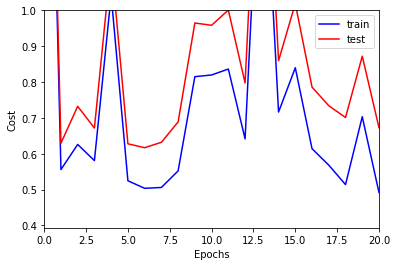

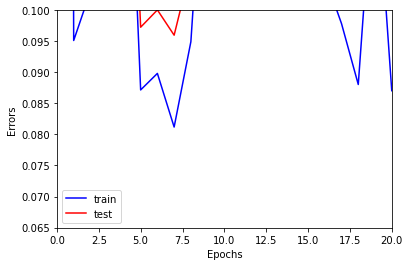

Train/test error after epoch 20: 0.087054, 0.102929


In [67]:
W,b = initialize_params(28*28, 10)

### START YOUR CODE ### 

learning_rate = 0.2
nepochs = 20
batchsize = 32
params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=batchsize, debug=True)

### END YOUR CODE ### 

metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
metrics.print_latest_errors()


### 1b Explore Hyper-Parameter Settings and Describe your Findings

Now run the training with different settings: 
* Different learning rate
* Different number of epochs
* Different batch size 

Explore which combination is best suited to obtain good test performance. Keep an eye on random estimates for the error rates due to random parameter initialisation and randomly shuffled mini-batches. 

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.

In [ ]:
learning_rates = [0.1, 0.2, 0.5, 1.0]
nepochs = [10,20,30,40]
batch_size = [16,32,64,128,512]


Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.118964, 0.125143
Train/test error after epoch 2: 0.108571, 0.118357
Train/test error after epoch 3: 0.176161, 0.184714
Train/test error after epoch 4: 0.110304, 0.116071
Train/test error after epoch 5: 0.096500, 0.106500
Train/test error after epoch 6: 0.097946, 0.110857
Train/test error after epoch 7: 0.121625, 0.135500
Train/test error after epoch 8: 0.096839, 0.108429
Train/test error after epoch 9: 0.109589, 0.118500
Train/test error after epoch 10: 0.240268, 0.247643
Train/test error after epoch 11: 0.089964, 0.106214
Train/test error after epoch 12: 0.083464, 0.095571
Train/test error after epoch 13: 0.151554, 0.162286
Train/test error after epoch 14: 0.070839, 0.085643
Train/test error after epoch 15: 0.076232, 0.090786
Train/test error after epoch 16: 0.082768, 0.094429
Train/test error after epoch 17: 0.074661, 0.087500
Train/test error after epoch 18: 0.099214, 0.110500
Train

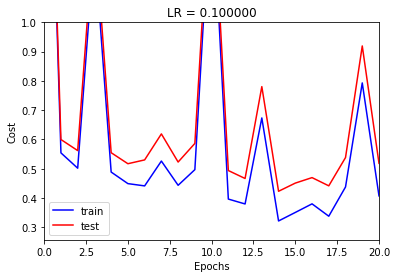

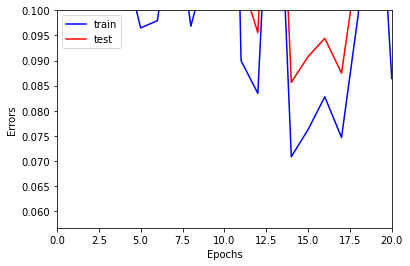

Train/test error after epoch 20: 0.086411, 0.102000
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.128000, 0.133857
Train/test error after epoch 2: 0.113464, 0.120714
Train/test error after epoch 3: 0.089482, 0.095500
Train/test error after epoch 4: 0.095196, 0.105929
Train/test error after epoch 5: 0.084661, 0.095786
Train/test error after epoch 6: 0.078732, 0.091929
Train/test error after epoch 7: 0.087625, 0.100071
Train/test error after epoch 8: 0.084786, 0.096071
Train/test error after epoch 9: 0.102786, 0.113643
Train/test error after epoch 10: 0.098571, 0.106429
Train/test error after epoch 11: 0.118768, 0.126286
Train/test error after epoch 12: 0.076982, 0.090571
Train/test error after epoch 13: 0.094643, 0.107000
Train/test error after epoch 14: 0.140554, 0.152643
Train/test error after epoch 15: 0.090893, 0.104571
Train/test error after epoch 16: 0.087786, 0.104857
Train/test error after epoch 17: 0.118214, 0.128714
Train

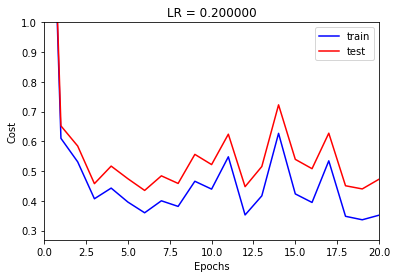

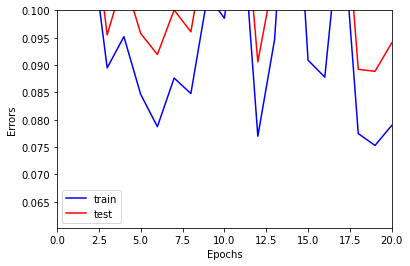

Train/test error after epoch 20: 0.078964, 0.094071
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.164196, 0.169214
Train/test error after epoch 2: 0.106554, 0.115571
Train/test error after epoch 3: 0.164143, 0.169143
Train/test error after epoch 4: 0.118589, 0.125214
Train/test error after epoch 5: 0.115714, 0.126500
Train/test error after epoch 6: 0.146179, 0.154929
Train/test error after epoch 7: 0.086768, 0.098071
Train/test error after epoch 8: 0.079857, 0.092929
Train/test error after epoch 9: 0.143375, 0.152857
Train/test error after epoch 10: 0.095286, 0.107929
Train/test error after epoch 11: 0.119732, 0.131000
Train/test error after epoch 12: 0.085679, 0.099429
Train/test error after epoch 13: 0.093268, 0.102429
Train/test error after epoch 14: 0.092786, 0.102286
Train/test error after epoch 15: 0.078589, 0.094714
Train/test error after epoch 16: 0.093500, 0.105643
Train/test error after epoch 17: 0.107696, 0.122214
Train

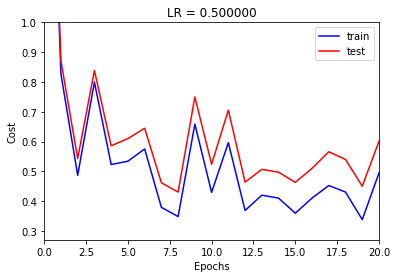

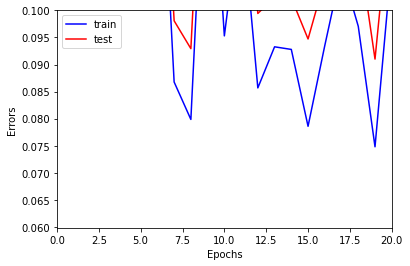

Train/test error after epoch 20: 0.109232, 0.122286
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.127893, 0.135571
Train/test error after epoch 2: 0.112446, 0.120143
Train/test error after epoch 3: 0.125179, 0.131786
Train/test error after epoch 4: 0.085839, 0.094571
Train/test error after epoch 5: 0.080000, 0.092071
Train/test error after epoch 6: 0.081196, 0.089643
Train/test error after epoch 7: 0.111625, 0.125571
Train/test error after epoch 8: 0.109982, 0.118429
Train/test error after epoch 9: 0.093714, 0.103643
Train/test error after epoch 10: 0.092304, 0.106143
Train/test error after epoch 11: 0.093625, 0.107000
Train/test error after epoch 12: 0.092446, 0.102357
Train/test error after epoch 13: 0.116375, 0.125929
Train/test error after epoch 14: 0.087518, 0.098500
Train/test error after epoch 15: 0.084107, 0.097857
Train/test error after epoch 16: 0.149304, 0.161286
Train/test error after epoch 17: 0.100911, 0.112357
Train

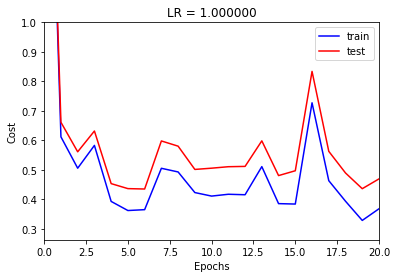

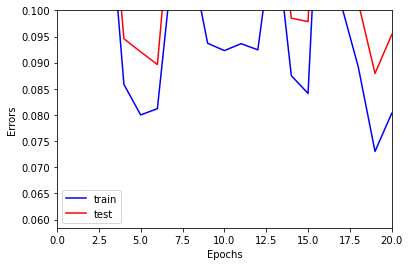

Train/test error after epoch 20: 0.080321, 0.095357


In [59]:
batch_size = 64
nepochs = 20
for learning_rates in [0.1, 0.2, 0.5, 1.0]:
    model, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=batch_size, debug=True)
    plt.title("LR = %f" % learning_rates)
    metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
    metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
    metrics.print_latest_errors()

    
    
#0.1 0.102000 
#0.2 0.094071, best
#0.5 0.122286
#1.0 0.095357


Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.198429, 0.200929
Train/test error after epoch 2: 0.137714, 0.143071
Train/test error after epoch 3: 0.124875, 0.135214
Train/test error after epoch 4: 0.093000, 0.100071
Train/test error after epoch 5: 0.109893, 0.120357
Train/test error after epoch 6: 0.121929, 0.132571
Train/test error after epoch 7: 0.111964, 0.120643
Train/test error after epoch 8: 0.103339, 0.115214
Train/test error after epoch 9: 0.108375, 0.121786
Train/test error after epoch 10: 0.111250, 0.123000
Train/test cost after epoch 10: 0.505631, 0.609804
Train/test error after epoch 10: 0.111250, 0.123000


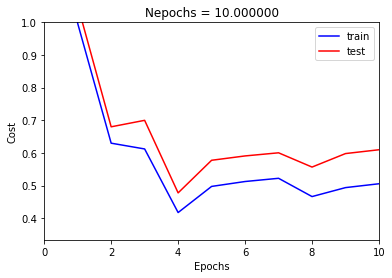

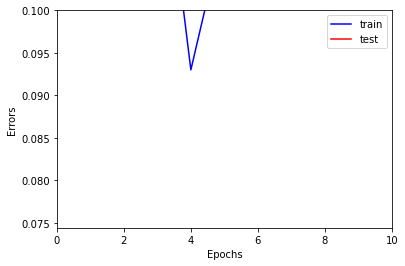

Train/test error after epoch 10: 0.111250, 0.123000
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.117000, 0.123786
Train/test error after epoch 2: 0.151036, 0.154929
Train/test error after epoch 3: 0.104250, 0.111214
Train/test error after epoch 4: 0.099250, 0.108643
Train/test error after epoch 5: 0.198554, 0.201500
Train/test error after epoch 6: 0.086571, 0.097214
Train/test error after epoch 7: 0.093339, 0.102714
Train/test error after epoch 8: 0.093357, 0.103643
Train/test error after epoch 9: 0.105268, 0.112929
Train/test error after epoch 10: 0.125232, 0.139929
Train/test error after epoch 11: 0.234268, 0.236857
Train/test error after epoch 12: 0.081536, 0.093643
Train/test error after epoch 13: 0.079000, 0.090571
Train/test error after epoch 14: 0.094571, 0.110071
Train/test error after epoch 15: 0.107482, 0.117286
Train/test error after epoch 16: 0.089321, 0.103143
Train/test error after epoch 17: 0.103393, 0.112714
Train

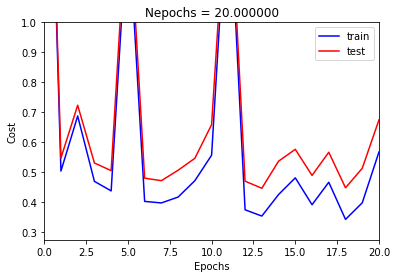

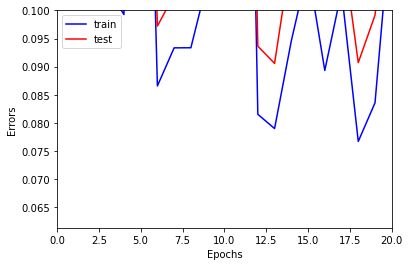

Train/test error after epoch 20: 0.117821, 0.127714
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.123589, 0.128571
Train/test error after epoch 2: 0.106089, 0.113571
Train/test error after epoch 3: 0.163643, 0.170357
Train/test error after epoch 4: 0.082304, 0.091571
Train/test error after epoch 5: 0.088732, 0.099571
Train/test error after epoch 6: 0.086554, 0.095286
Train/test error after epoch 7: 0.211036, 0.219571
Train/test error after epoch 8: 0.085429, 0.097214
Train/test error after epoch 9: 0.093214, 0.105071
Train/test error after epoch 10: 0.079393, 0.093357
Train/test error after epoch 11: 0.124946, 0.138357
Train/test error after epoch 12: 0.085857, 0.099357
Train/test error after epoch 13: 0.074893, 0.089929
Train/test error after epoch 14: 0.105518, 0.116286
Train/test error after epoch 15: 0.194089, 0.200929
Train/test error after epoch 16: 0.089696, 0.107714
Train/test error after epoch 17: 0.105625, 0.114071
Train

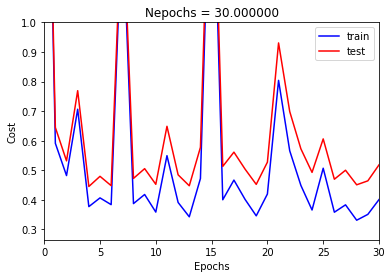

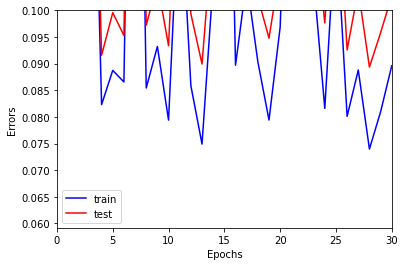

Train/test error after epoch 30: 0.089589, 0.102714
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.113268, 0.117214
Train/test error after epoch 2: 0.140875, 0.151071
Train/test error after epoch 3: 0.103464, 0.112571
Train/test error after epoch 4: 0.090732, 0.099429
Train/test error after epoch 5: 0.079643, 0.089500
Train/test error after epoch 6: 0.087036, 0.096857
Train/test error after epoch 7: 0.115446, 0.127429
Train/test error after epoch 8: 0.098464, 0.107000
Train/test error after epoch 9: 0.089304, 0.102143
Train/test error after epoch 10: 0.086804, 0.098357
Train/test error after epoch 11: 0.086304, 0.101357
Train/test error after epoch 12: 0.094839, 0.106429
Train/test error after epoch 13: 0.114714, 0.130643
Train/test error after epoch 14: 0.088036, 0.100143
Train/test error after epoch 15: 0.087911, 0.100857
Train/test error after epoch 16: 0.131518, 0.141714
Train/test error after epoch 17: 0.135857, 0.149214
Train

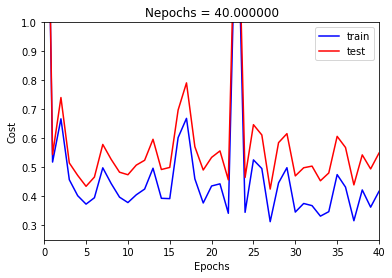

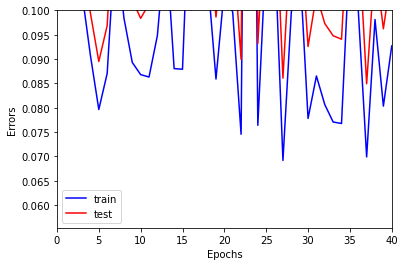

Train/test error after epoch 40: 0.092696, 0.107857
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.095661, 0.101143
Train/test error after epoch 2: 0.194518, 0.200857
Train/test error after epoch 3: 0.086054, 0.093000
Train/test error after epoch 4: 0.107946, 0.115357
Train/test error after epoch 5: 0.154982, 0.163857
Train/test error after epoch 6: 0.131036, 0.139714
Train/test error after epoch 7: 0.084536, 0.097429
Train/test error after epoch 8: 0.113429, 0.122357
Train/test error after epoch 9: 0.108286, 0.117357
Train/test error after epoch 10: 0.158500, 0.163857
Train/test error after epoch 11: 0.096464, 0.109286
Train/test error after epoch 12: 0.080589, 0.091000
Train/test error after epoch 13: 0.092304, 0.104000
Train/test error after epoch 14: 0.082929, 0.098000
Train/test error after epoch 15: 0.181339, 0.190643
Train/test error after epoch 16: 0.121482, 0.131857
Train/test error after epoch 17: 0.155946, 0.168857
Train

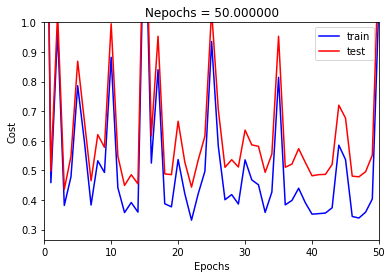

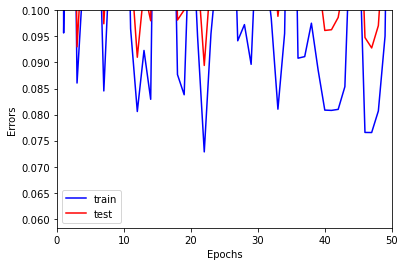

Train/test error after epoch 50: 0.182875, 0.195571


In [66]:
learning_rate = 0.2
batch_size = 64
for nepochs in [10,20,30,40,50]:
    model, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=batch_size, debug=True)
    plt.title("Nepochs = %f" % nepochs)
    metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
    metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
    metrics.print_latest_errors()
    
    
#10 0.117857
#20 0.124857
#30 0.099714, best
#40 0.117000
#50 0.108143

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test error after epoch 1: 0.104357, 0.111786
Train/test error after epoch 2: 0.116446, 0.123571
Train/test error after epoch 3: 0.101393, 0.107643
Train/test error after epoch 4: 0.129750, 0.141929
Train/test error after epoch 5: 0.093982, 0.104714
Train/test error after epoch 6: 0.085946, 0.095071
Train/test error after epoch 7: 0.098268, 0.111786
Train/test error after epoch 8: 0.110375, 0.126429
Train/test error after epoch 9: 0.141286, 0.151429
Train/test error after epoch 10: 0.087107, 0.098714
Train/test error after epoch 11: 0.115554, 0.125429
Train/test error after epoch 12: 0.093839, 0.111000
Train/test error after epoch 13: 0.153964, 0.163214
Train/test error after epoch 14: 0.092946, 0.105429
Train/test error after epoch 15: 0.096714, 0.110000
Train/test error after epoch 16: 0.082929, 0.097857
Train/test error after epoch 17: 0.111339, 0.124500
Train/test error after epoch 18: 0.145054, 0.160000
Trai

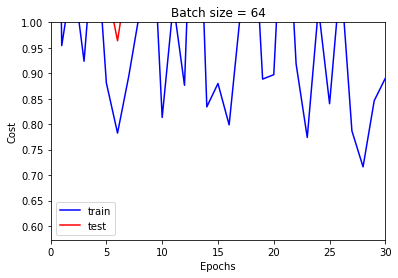

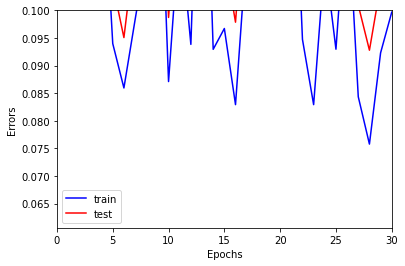

Train/test error after epoch 30: 0.099679, 0.115500
Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test error after epoch 1: 0.114071, 0.119143
Train/test error after epoch 2: 0.113446, 0.123071
Train/test error after epoch 3: 0.082839, 0.092143
Train/test error after epoch 4: 0.098536, 0.109929
Train/test error after epoch 5: 0.129339, 0.137071
Train/test error after epoch 6: 0.119589, 0.129214
Train/test error after epoch 7: 0.122339, 0.129643
Train/test error after epoch 8: 0.085089, 0.097500
Train/test error after epoch 9: 0.087000, 0.100786
Train/test error after epoch 10: 0.095375, 0.105429
Train/test error after epoch 11: 0.119679, 0.132071
Train/test error after epoch 12: 0.112982, 0.123929
Train/test error after epoch 13: 0.133982, 0.148643
Train/test error after epoch 14: 0.101982, 0.116143
Train/test error after epoch 15: 0.103911, 0.116429
Train/test error after epoch 16: 0.090714, 0.105929
Train/test error after epoch 17: 0.113304, 0.129000
Trai

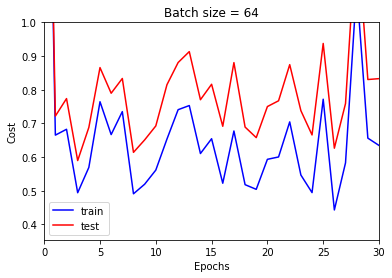

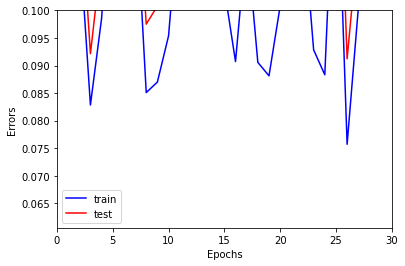

Train/test error after epoch 30: 0.109286, 0.127786
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test error after epoch 1: 0.140446, 0.144000
Train/test error after epoch 2: 0.153071, 0.160500
Train/test error after epoch 3: 0.096589, 0.108571
Train/test error after epoch 4: 0.124661, 0.134643
Train/test error after epoch 5: 0.100625, 0.108571
Train/test error after epoch 6: 0.084589, 0.096857
Train/test error after epoch 7: 0.087304, 0.099714
Train/test error after epoch 8: 0.138429, 0.151214
Train/test error after epoch 9: 0.129589, 0.137143
Train/test error after epoch 10: 0.081804, 0.095214
Train/test error after epoch 11: 0.147839, 0.157500
Train/test error after epoch 12: 0.159107, 0.166286
Train/test error after epoch 13: 0.129339, 0.139143
Train/test error after epoch 14: 0.081071, 0.093429
Train/test error after epoch 15: 0.106089, 0.120000
Train/test error after epoch 16: 0.091339, 0.104714
Train/test error after epoch 17: 0.086643, 0.096571
Train

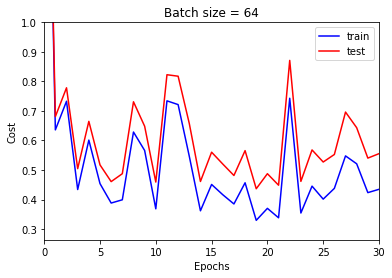

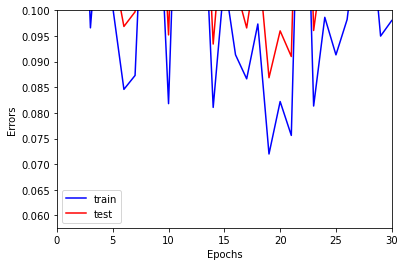

Train/test error after epoch 30: 0.098018, 0.108929
Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test error after epoch 1: 0.092286, 0.100071
Train/test error after epoch 2: 0.112804, 0.121786
Train/test error after epoch 3: 0.105107, 0.112214
Train/test error after epoch 4: 0.098518, 0.106429
Train/test error after epoch 5: 0.092732, 0.102214
Train/test error after epoch 6: 0.101982, 0.110286
Train/test error after epoch 7: 0.149018, 0.152429
Train/test error after epoch 8: 0.162554, 0.173214
Train/test error after epoch 9: 0.095696, 0.106286
Train/test error after epoch 10: 0.099107, 0.110643
Train/test error after epoch 11: 0.104071, 0.120214
Train/test error after epoch 12: 0.202839, 0.211500
Train/test error after epoch 13: 0.077625, 0.088929
Train/test error after epoch 14: 0.082214, 0.095214
Train/test error after epoch 15: 0.122500, 0.132071
Train/test error after epoch 16: 0.169018, 0.184571
Train/test error after epoch 17: 0.139000, 0.152929
Trai

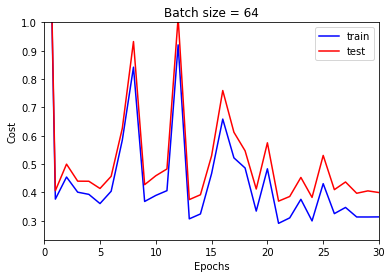

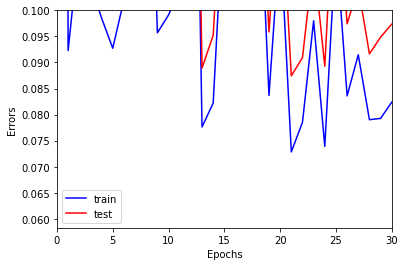

Train/test error after epoch 30: 0.082375, 0.097357
Optimisation with batchsize 512 and 109 number of batches per epoch.
Train/test error after epoch 1: 0.158089, 0.161857
Train/test error after epoch 2: 0.116821, 0.122000
Train/test error after epoch 3: 0.108339, 0.115643
Train/test error after epoch 4: 0.172911, 0.182714
Train/test error after epoch 5: 0.100161, 0.104071
Train/test error after epoch 6: 0.121982, 0.125071
Train/test error after epoch 7: 0.124571, 0.133357
Train/test error after epoch 8: 0.093875, 0.101929
Train/test error after epoch 9: 0.089607, 0.100786
Train/test error after epoch 10: 0.091607, 0.100786
Train/test error after epoch 11: 0.132643, 0.140429
Train/test error after epoch 12: 0.081982, 0.090214
Train/test error after epoch 13: 0.081625, 0.091857
Train/test error after epoch 14: 0.110286, 0.119143
Train/test error after epoch 15: 0.078929, 0.088500
Train/test error after epoch 16: 0.136179, 0.142929
Train/test error after epoch 17: 0.079857, 0.090500
Trai

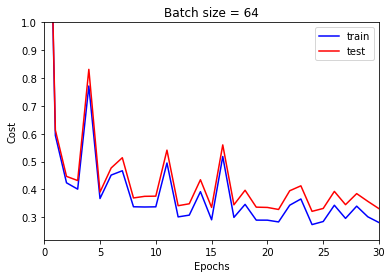

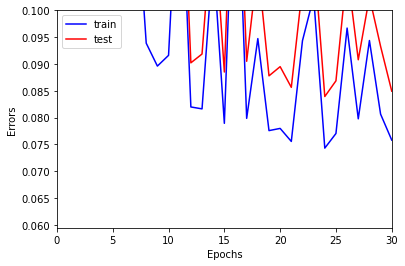

Train/test error after epoch 30: 0.075804, 0.084929


In [68]:
learning_rate = 0.2
nepochs = 30
for batchsize in [16,32,64,128,512]:
    model, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=batchsize, debug=True)
    plt.title("Batch size = %i" % batch_size)
    metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
    metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
    metrics.print_latest_errors()
    
    
#16 0.115500
#32 0.127786
#64 0.108929
#128 0.097357
#512 0.084929 , best

#### YOUR FINDINGS ...



...



...

### 1c Compute the Error Rates for the individual Digits

Now compute and print (or plot) the rate of misclassified images per digit (i.e. How many digits with label k are not been classified as label k).

Which one seems most difficult to classify?

Plot a few images of the wrongly classified images that have the label of the class that is most difficult to classify.  

<ipython-input-4-b7644e9398ea>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, index+1)


[[3 1 0 7 4]]
[7 4 2 9 2]


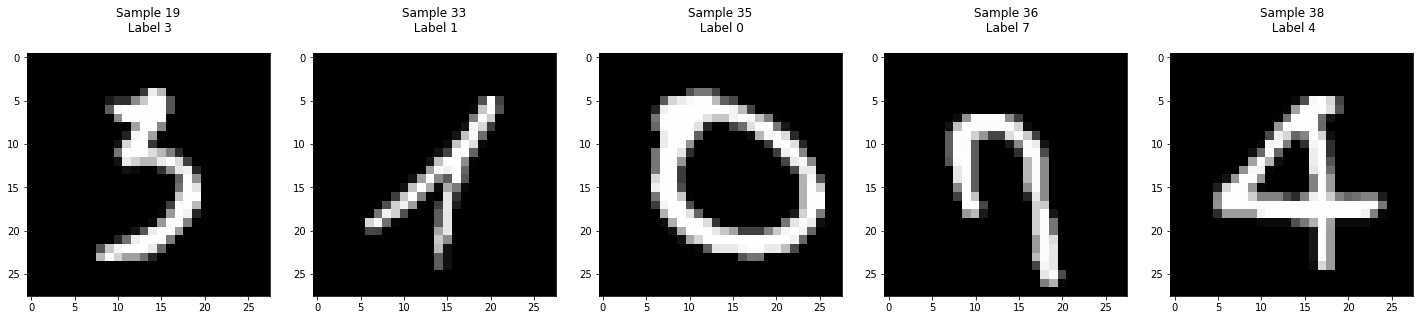

In [73]:
W = params['W']
b = params['b']
y_pred = predict(W,b,x_test)

### START YOUR CODE ### 
import pandas as pd
import seaborn as sns

train_error = pd.DataFrame(np.zeros((10, 10)))
test_error = pd.DataFrame(np.zeros((10, 10)))

for n1, n2 in itertools.combinations(list(range(10)), 2):
    selected_digits = (n1, n2)
    
    
### END YOUR CODE ### 

In [81]:
import pandas as pd
import seaborn as sns

train_error = pd.DataFrame(np.zeros((10, 10)))
test_error = pd.DataFrame(np.zeros((10, 10)))

for n1, n2 in itertools.combinations(list(range(10)), 2):
    selected_digits = (n1, n2)

    x_train1, x_test1, y_train, y_test = prepare_train_test(x, y, test_size=0.20)
    x_train,x_test = normalize(x_train1,x_test1)
    
    W,b = initialize_params(28*28, 10)
    model, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=30, alpha = 0.2, batchsize=32, debug=True)
    
    train_errors = int(min(metrics.train_errors)*1000) / 10
    test_errors = int(min(metrics.test_errors)*1000) / 10
    train_error.loc[n1, n2] = train_errors
    train_error.loc[n2, n1] = train_errors
    test_error.loc[n1, n2] = test_errors
    test_error.loc[n2, n1] = test_errors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training errors")
ax2.set_title("Test errors")
sns.heatmap(train_error, annot=True, ax=ax1)

Shape training set:  (784, 56000) (1, 56000)
Shape test set:      (784, 14000) (1, 14000)
Optimisation with batchsize 32 and 1750 number of batches per epoch.


ValueError: cannot reshape array of size 150528 into shape (784,512)

__Plot some misclassified of the most difficult class:__

8


<ipython-input-4-b7644e9398ea>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, index+1)


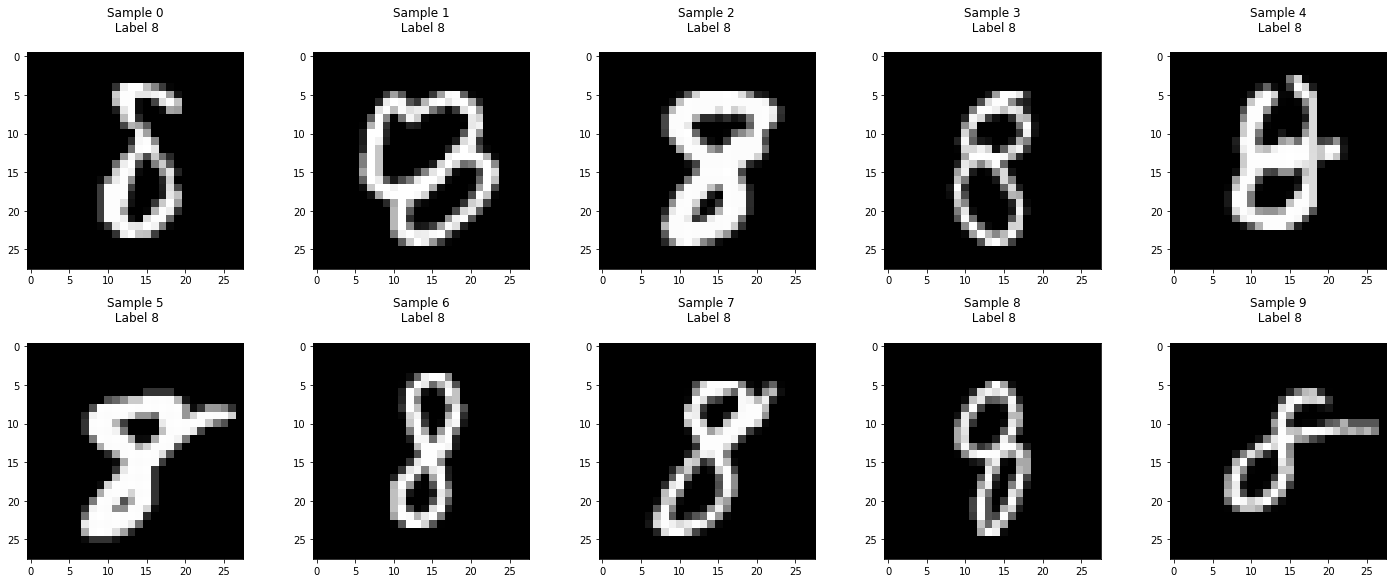

In [24]:
### START YOUR CODE ### 










### END YOUR CODE ### 

### 1d Analyse Wrongly Classified Images

For the given best choice of hyper-parameters explore the mis-classified images.
Select the images the model was wrong and most uncertain with and characterize which digits were most often confused and why.
For plotting and inspecting, you can use the `plot_digits`-function defined above. 

<ipython-input-4-b7644e9398ea>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, index+1)


[[3 1 0 7 4 7 9 3 9 8 0 2 7 9 3 5 2 9 5 8 8 9 4 9 8]]
[7 4 2 9 2 4 8 5 5 2 3 1 4 7 8 8 4 7 1 7 1 7 9 7 3]


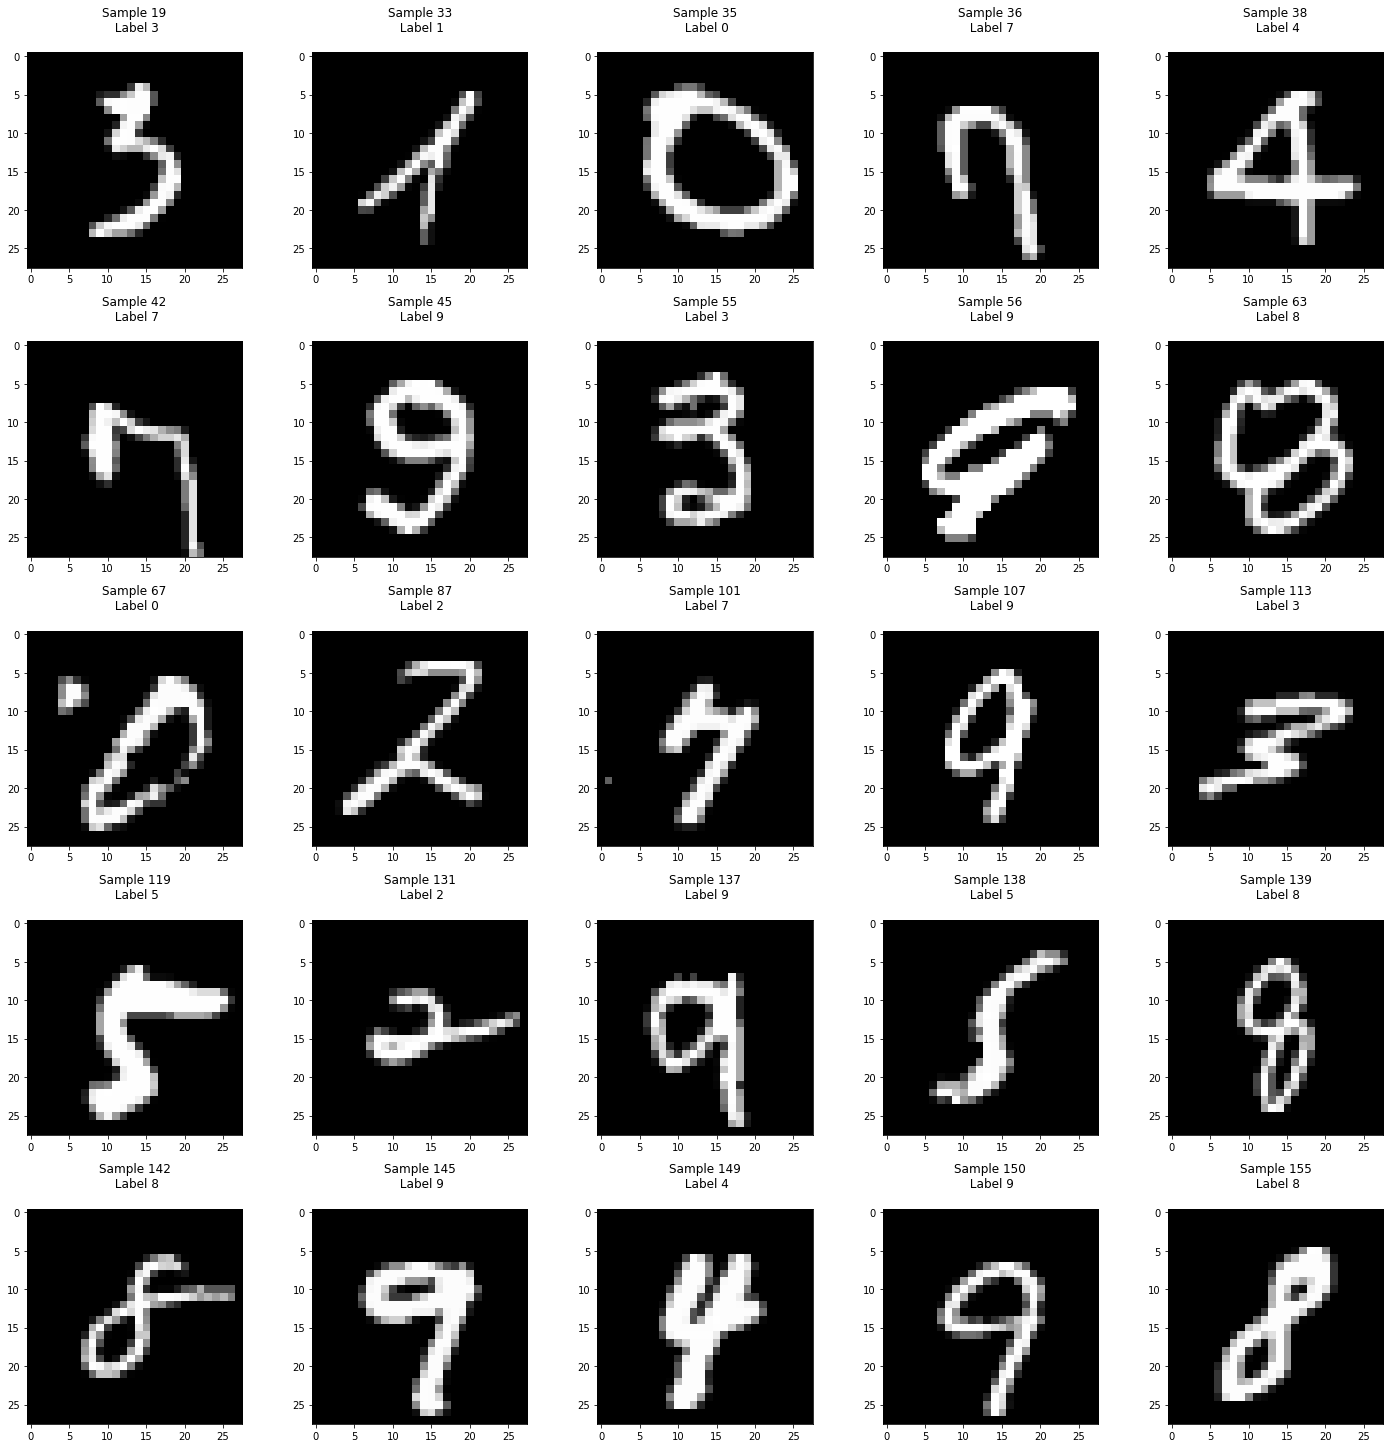

In [80]:
### START YOUR CODE ### 

yhat = np.argmax(y_pred, axis=0)
indices = np.where(yhat != y_test)[1]
plot_digits(x_test, y_test, indices[0:25], shape)
print(y_test[:,indices[0:25]])
print(yhat[indices[0:25]])


### END YOUR CODE ### 

### Plot the Trained Weights as Image 

The following cell allows you to plot the trained weights as images and the trained bias for the 10 digits. This helps to understand what the given model actually is doing. For larger (deeper) models, this won't be that easy any more. 

__QUESTION:__ 
* What could you tell about the predictions made by the model if one of the bias terms would be much larger than all the others (e.g. $b_5=10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

* What could you tell about the predictions made by the model if one of the bias terms would be much smaller than all the others (e.g. $b_5=-10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

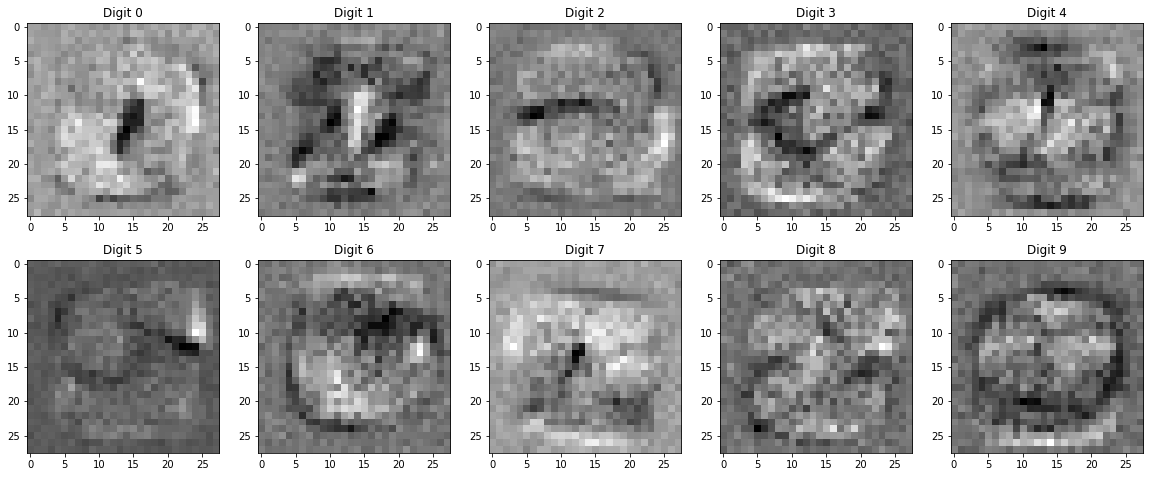

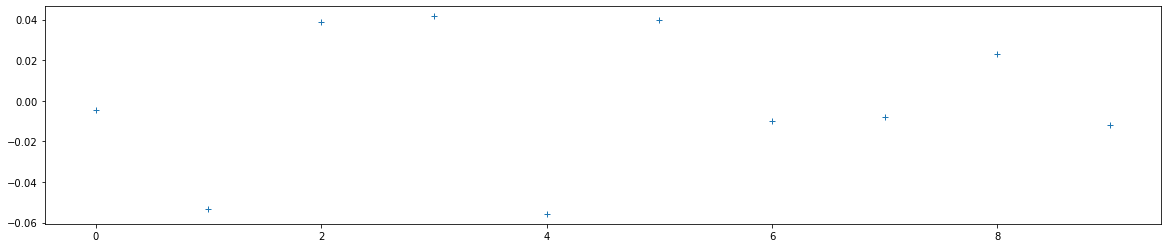

In [26]:
weights = params['W']
biases = params['b']
cols = 5
rows = 2
plt.figure(figsize=(20,4*rows))
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.reshape(weights[i], (28,28)), cmap=plt.cm.gray)
    plt.title('Digit %i'%i, fontsize = 12)

plt.figure(figsize=(20,4))
plt.plot(range(10), [biases[i] for i in range(10)], '+')


### 1f Analyse Weights Initialisation 

Implement and compare the weights initialisation strategies 1.-3.

__QUESTION:__ Are there significant differences in the learning, the hyper parameter settings needed, the resulting error rates (and misclassified digits) for the different initialisation strategies? 